In [1]:
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

from joblib import dump, load
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from sklearn.feature_selection import RFECV

# House Price Prediction

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [3]:
def try_encodings(file_path):
    #standard encodings we use
    encodings = ['utf-8', 'latin1', 'iso-8859-1', 'windows-1252', 'ascii', 'utf-16', 'utf-32']

    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"Success encoding: {encoding}")
            return df
        except Exception as e:
            print(f"Failed encoding: {encoding} - Error: {e}")

    print("None of the encodings worked correctly.")
    return None

file_path = '/kaggle/input/home-data-for-ml-course/train.csv'

df = try_encodings(file_path)

Success encoding: utf-8


In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(f"feature : {df.shape[1]}\nrow : {df.shape[0]}")
df.columns

feature : 81
row : 1460


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
print(df.isna().sum().sum())

7829


# Data Cleaning

## null values detecting

In [9]:
def nullcolumns(df):
    # Thresholds dictionary
    thresh_hold = {
        100: 'very low',
        200: 'low',
        300: 'normal',
        500: 'high',
        1000: 'very high',
        1001:'too much'
    }
    
    # Calculate null values
    null_values = df.isnull().sum()
    condition2 = null_values != 0
    
    # Initialize the dictionary to store the results
    null_columns = {key: [] for key in thresh_hold.values()}
    print(null_columns)
    # Iterate through the thresholds
    for key, value in thresh_hold.items():
        print(value)
        status = 'Below'
        condition1 = null_values <= key
        
        # Check for the condition if it's "very high"
        if value == "very high":
            condition1 = null_values > key
            value = "too much"
            status = "Over"
        
        # Filter columns based on the conditions
        features_with_many_nulls = null_values[(condition1) & (condition2)]

        condition2 = null_values >= key
        # Check if there are no features with the current condition
        if features_with_many_nulls.index.empty:
            # condition2 = null_values >= key
            continue
            
        elif not(features_with_many_nulls.index.empty):
            # Add columns to the dictionary
            for column in features_with_many_nulls.index:
                null_columns[value].append(column)
            
            
    
    # Display the final dictionary of null columns
    # print(null_columns)
    return null_columns
null_columns=nullcolumns(df)

{'very low': [], 'low': [], 'normal': [], 'high': [], 'very high': [], 'too much': []}
very low
low
normal
high
very high
too much


In [10]:
df.shape
null_columns

{'very low': ['MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond'],
 'low': [],
 'normal': ['LotFrontage'],
 'high': [],
 'very high': [],
 'too much': ['Alley', 'PoolQC', 'Fence', 'MiscFeature']}

In [11]:
delete_keys=[]
for key,value in null_columns.items():
    try:
        if ((key == 'too much') or (key== 'very high')) :
            df.drop(columns=value, inplace=True)
            delete_keys.append(key)
            print(key,'is to be deleted')
        elif(value==[]):
            print(key,'is empty',value, 'to be deleted')
            delete_keys.append(key)
    except:
        delete_keys.append(key)
        print(error)
print('to be deleted: ',delete_keys)


low is empty [] to be deleted
high is empty [] to be deleted
very high is to be deleted
too much is to be deleted
to be deleted:  ['low', 'high', 'very high', 'too much']


In [12]:
for column in delete_keys:
    if column in null_columns:
        del null_columns[column]

In [13]:
null_columns

{'very low': ['MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond'],
 'normal': ['LotFrontage']}

In [14]:
print(df.isna().sum().sum())

df.shape

2422


(1460, 77)

In [15]:
df.isnull().sum().sum()

2422

In [16]:
null_col=[]
for key,value in null_columns.items():
    null_col.append(value)
null_col

[['MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond'],
 ['LotFrontage']]

In [17]:
sf=df.select_dtypes(include=['object'])
sf.isnull().sum().sum()

2074

In [18]:
for column in sf.columns:
    mode_value = df[column].mode()[0]  # Get the most frequent category
    df[column] = df[column].fillna(mode_value)
df.isnull().sum().sum()

348

In [19]:
nf=df.select_dtypes(include=['number'])


In [20]:
df.isnull().sum().sum()

348

In [21]:
mean_values = nf.mean()
print(mean_values)
# Replace missing values with mean
df.fillna(mean_values, inplace=True)

Id                  730.500000
MSSubClass           56.897260
LotFrontage          70.049958
LotArea           10516.828082
OverallQual           6.099315
OverallCond           5.575342
YearBuilt          1971.267808
YearRemodAdd       1984.865753
MasVnrArea          103.685262
BsmtFinSF1          443.639726
BsmtFinSF2           46.549315
BsmtUnfSF           567.240411
TotalBsmtSF        1057.429452
1stFlrSF           1162.626712
2ndFlrSF            346.992466
LowQualFinSF          5.844521
GrLivArea          1515.463699
BsmtFullBath          0.425342
BsmtHalfBath          0.057534
FullBath              1.565068
HalfBath              0.382877
BedroomAbvGr          2.866438
KitchenAbvGr          1.046575
TotRmsAbvGrd          6.517808
Fireplaces            0.613014
GarageYrBlt        1978.506164
GarageCars            1.767123
GarageArea          472.980137
WoodDeckSF           94.244521
OpenPorchSF          46.660274
EnclosedPorch        21.954110
3SsnPorch             3.409589
ScreenPo

In [22]:
df.isnull().sum().sum()

0

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [24]:
skewness=nf.skew()

In [25]:
threshold = 1
high_skew_columns = skewness[abs(skewness) > threshold].index

In [26]:
#taking the high skewed data
hsd= df[high_skew_columns]
print("\nDataFrame with High-Skewed Columns:\n", hsd.columns)


DataFrame with High-Skewed Columns:
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice'],
      dtype='object')


In [27]:
hsd.skew()

MSSubClass        1.407657
LotFrontage       2.384950
LotArea          12.207688
MasVnrArea        2.676412
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
TotalBsmtSF       1.524255
1stFlrSF          1.376757
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtHalfBath      4.103403
KitchenAbvGr      4.488397
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
SalePrice         1.882876
dtype: float64

In [28]:
print(hsd.select_dtypes(include='number').columns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice'],
      dtype='object')


In [29]:
df.select_dtypes(include='number').skew()

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.384950
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.676412
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.668175
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

## transform using log(x)

In [30]:
ldf=df.copy()
# Apply log transformation
for column in high_skew_columns:
    ldf[column] = np.log1p(df[column])

## transformation using square root

In [31]:
sdf=df.copy()
for column in high_skew_columns:
    sdf[column] = np.sqrt(df[column])


## transformation using box cox

In [32]:
from scipy import stats
bdf=df.copy()
for column in high_skew_columns:
    bdf[column], _ = stats.boxcox(df[column] + 1)  # Adding 1 to avoid issues with zero values

## chosing the best one

In [33]:
# Calculate skewness for numerical columns in each DataFrame
sdfr_skew = df[hsd.columns].select_dtypes(include='number').skew()
sdf_skew = sdf[hsd.columns].select_dtypes(include='number').skew()
ldf_skew = ldf[hsd.columns].select_dtypes(include='number').skew()
bdf_skew = bdf[hsd.columns].select_dtypes(include='number').skew()

# Combine skewness results into a new DataFrame
skewness_df = pd.DataFrame({
    'real df': sdf_skew,
    'square root': sdf_skew,
    'log(10)': ldf_skew,
    'box cox': bdf_skew
})

In [34]:
skewness_df

,real df,square root,log(10),box cox
MSSubClass,0.762448,0.762448,0.248997,0.069019
LotFrontage,0.368212,0.368212,-0.891977,0.173047
LotArea,4.139714,4.139714,-0.137404,0.026569
MasVnrArea,1.033300,1.033300,0.481120,0.405245
BsmtFinSF1,-0.029946,-0.029946,-0.618410,-0.411401
BsmtFinSF2,3.036810,3.036810,2.523694,2.425650
TotalBsmtSF,-1.274537,-1.274537,-5.154670,0.232534
1stFlrSF,0.624263,0.624263,0.080114,-0.001106
LowQualFinSF,8.065393,8.065393,7.460317,7.299413
GrLivArea,0.594255,0.594255,-0.006140,0.000171


i'll use box cox as it is the nearest to zero.

In [35]:
for column in high_skew_columns:
    df[column] =bdf[column]

In [36]:
def nfvalue(df):
    nf= df.select_dtypes(include=('number'))
    return nf
nf.skew()

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

## deleting useless features

In [37]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [38]:
features_to_delete = ['Id', 'Street', 'Utilities','MSSubClass', 
                      'Condition1','Condition2','RoofStyle','RoofMatl',
                     'LandContour','LandSlope','LowQualFinSF','MiscVal','MoSold']

# Drop the features from the DataFrame
df = df.drop(columns=features_to_delete)

In [39]:
# Define the mapping for GarageQual
quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}

# Apply the mapping to convert GarageQual to numerical values
df['GarageQual'] = df['GarageQual'].map(quality_mapping)

In [40]:
# Calculate new features
df['AgeOfHouse'] = df['YrSold'] - df['YearBuilt']
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['TotalBsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['HouseQuality'] = df['OverallQual'] * df['OverallCond']
df['LotRatio'] = df['LotFrontage'] / df['LotArea']
df['GarageScore'] = df['GarageCars'] * df['GarageArea'] * df['GarageQual']

# Drop original features if they are now redundant
features_to_drop = ['YrSold', 'YearBuilt', 'YearRemodAdd', 'OpenPorchSF', 'GarageQual', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'OverallQual', 'OverallCond', 'LotFrontage', 'LotArea']
df.drop(columns=features_to_drop, inplace=True)

print("Feature engineering and dropping redundant features completed. Here are the first few rows of the new DataFrame:")
df.head()

Feature engineering and dropping redundant features completed. Here are the first few rows of the new DataFrame:


,MSZoning,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,...,SaleCondition,SalePrice,AgeOfHouse,RemodelAge,TotalBath,TotalPorchSF,TotalBsmtFinSF,HouseQuality,LotRatio,GarageScore
0,RL,Reg,Inside,CollgCr,1Fam,2Story,VinylSd,VinylSd,BrkFace,3.039762,...,Normal,7.932276,5,5,3.500000,4.227899,15.235367,35,1.118691,3288
1,RL,Reg,FR2,Veenker,1Fam,1Story,MetalSd,MetalSd,BrkFace,0.000000,...,Normal,7.877934,31,31,2.019743,0.000000,16.750862,48,1.221613,2760
2,RL,IR1,Inside,CollgCr,1Fam,2Story,VinylSd,VinylSd,BrkFace,2.983148,...,Normal,7.959280,7,6,3.500000,3.844769,13.632899,35,1.104203,3648
3,RL,IR1,Corner,Crawfor,1Fam,2Story,Wd Sdng,Wd Shng,BrkFace,0.000000,...,Abnorml,7.774636,91,36,2.000000,4.363332,10.593523,35,1.057837,5778
4,RL,IR1,FR2,NoRidge,1Fam,2Story,VinylSd,VinylSd,BrkFace,3.197720,...,Normal,8.002532,8,8,3.500000,4.559556,14.902455,40,1.192189,7524


In [41]:
df.shape

(1460, 58)

# test.csv cleaning

In [42]:
df_test= pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [44]:
df_test.shape

(1459, 80)

In [45]:
df_test.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [46]:
Id=pd.DataFrame()
Id=df_test['Id']

In [47]:
df_test = df_test.drop(columns=features_to_delete)
df_test

,MSZoning,LotFrontage,LotArea,Alley,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,YrSold,SaleType,SaleCondition
0,RH,80.0,11622,NaN,Reg,Inside,NAmes,1Fam,1Story,5,...,0,0,120,0,NaN,MnPrv,NaN,2010,WD,Normal
1,RL,81.0,14267,NaN,IR1,Corner,NAmes,1Fam,1Story,6,...,0,0,0,0,NaN,NaN,Gar2,2010,WD,Normal
2,RL,74.0,13830,NaN,IR1,Inside,Gilbert,1Fam,2Story,5,...,0,0,0,0,NaN,MnPrv,NaN,2010,WD,Normal
3,RL,78.0,9978,NaN,IR1,Inside,Gilbert,1Fam,2Story,6,...,0,0,0,0,NaN,NaN,NaN,2010,WD,Normal
4,RL,43.0,5005,NaN,IR1,Inside,StoneBr,TwnhsE,1Story,8,...,0,0,144,0,NaN,NaN,NaN,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,21.0,1936,NaN,Reg,Inside,MeadowV,Twnhs,2Story,4,...,0,0,0,0,NaN,NaN,NaN,2006,WD,Normal
1455,RM,21.0,1894,NaN,Reg,Inside,MeadowV,TwnhsE,2Story,4,...,0,0,0,0,NaN,NaN,NaN,2006,WD,Abnorml
1456,RL,160.0,20000,NaN,Reg,Inside,Mitchel,1Fam,1Story,5,...,0,0,0,0,NaN,NaN,NaN,2006,WD,Abnorml
1457,RL,62.0,10441,NaN,Reg,Inside,Mitchel,1Fam,SFoyer,5,...,0,0,0,0,NaN,MnPrv,Shed,2006,WD,Normal


In [48]:
len(df_test.columns)

67

In [49]:
df_test.isnull().sum()

MSZoning            4
LotFrontage       227
LotArea             0
Alley            1352
LotShape            0
                 ... 
Fence            1169
MiscFeature      1408
YrSold              0
SaleType            1
SaleCondition       0
Length: 67, dtype: int64

In [50]:
# Apply the mapping to convert GarageQual to numerical values
df_test['GarageQual'] = df_test['GarageQual'].map(quality_mapping)

In [51]:
# Calculate new features
df_test['AgeOfHouse'] = df_test['YrSold'] - df_test['YearBuilt']
df_test['RemodelAge'] = df_test['YrSold'] - df_test['YearRemodAdd']
df_test['TotalBath'] = df_test['FullBath'] + 0.5 * df_test['HalfBath'] + df_test['BsmtFullBath'] + 0.5 * df_test['BsmtHalfBath']
df_test['TotalPorchSF'] = df_test['OpenPorchSF'] + df_test['EnclosedPorch'] + df_test['3SsnPorch'] + df_test['ScreenPorch']
df_test['TotalBsmtFinSF'] = df_test['BsmtFinSF1'] + df_test['BsmtFinSF2']
df_test['HouseQuality'] = df_test['OverallQual'] * df_test['OverallCond']
df_test['LotRatio'] = df_test['LotFrontage'] / df_test['LotArea']
df_test['GarageScore'] = df_test['GarageCars'] * df_test['GarageArea'] * df_test['GarageQual']

# Drop original features if they are now redundant
features_to_drop = ['YrSold', 'YearBuilt', 'YearRemodAdd', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'OverallQual', 'OverallCond', 'LotFrontage', 'LotArea']
df_test.drop(columns=features_to_drop, inplace=True)

print("Feature engineering and dropping redundant features completed. Here are the first few rows of the new DataFrame:")
df_test.head()

Feature engineering and dropping redundant features completed. Here are the first few rows of the new DataFrame:


,MSZoning,Alley,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,...,SaleType,SaleCondition,AgeOfHouse,RemodelAge,TotalBath,TotalPorchSF,TotalBsmtFinSF,HouseQuality,LotRatio,GarageScore
0,RH,NaN,Reg,Inside,NAmes,1Fam,1Story,VinylSd,VinylSd,NaN,...,WD,Normal,49,49,1.0,120,612.0,30,0.006883,2190.0
1,RL,NaN,IR1,Corner,NAmes,1Fam,1Story,Wd Sdng,Wd Sdng,BrkFace,...,WD,Normal,52,52,1.5,36,923.0,36,0.005677,936.0
2,RL,NaN,IR1,Inside,Gilbert,1Fam,2Story,VinylSd,VinylSd,NaN,...,WD,Normal,13,12,2.5,34,791.0,25,0.005351,2892.0
3,RL,NaN,IR1,Inside,Gilbert,1Fam,2Story,VinylSd,VinylSd,BrkFace,...,WD,Normal,12,12,2.5,36,602.0,36,0.007817,2820.0
4,RL,NaN,IR1,Inside,StoneBr,TwnhsE,1Story,HdBoard,HdBoard,NaN,...,WD,Normal,18,18,2.0,226,263.0,40,0.008591,3036.0


# model building

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

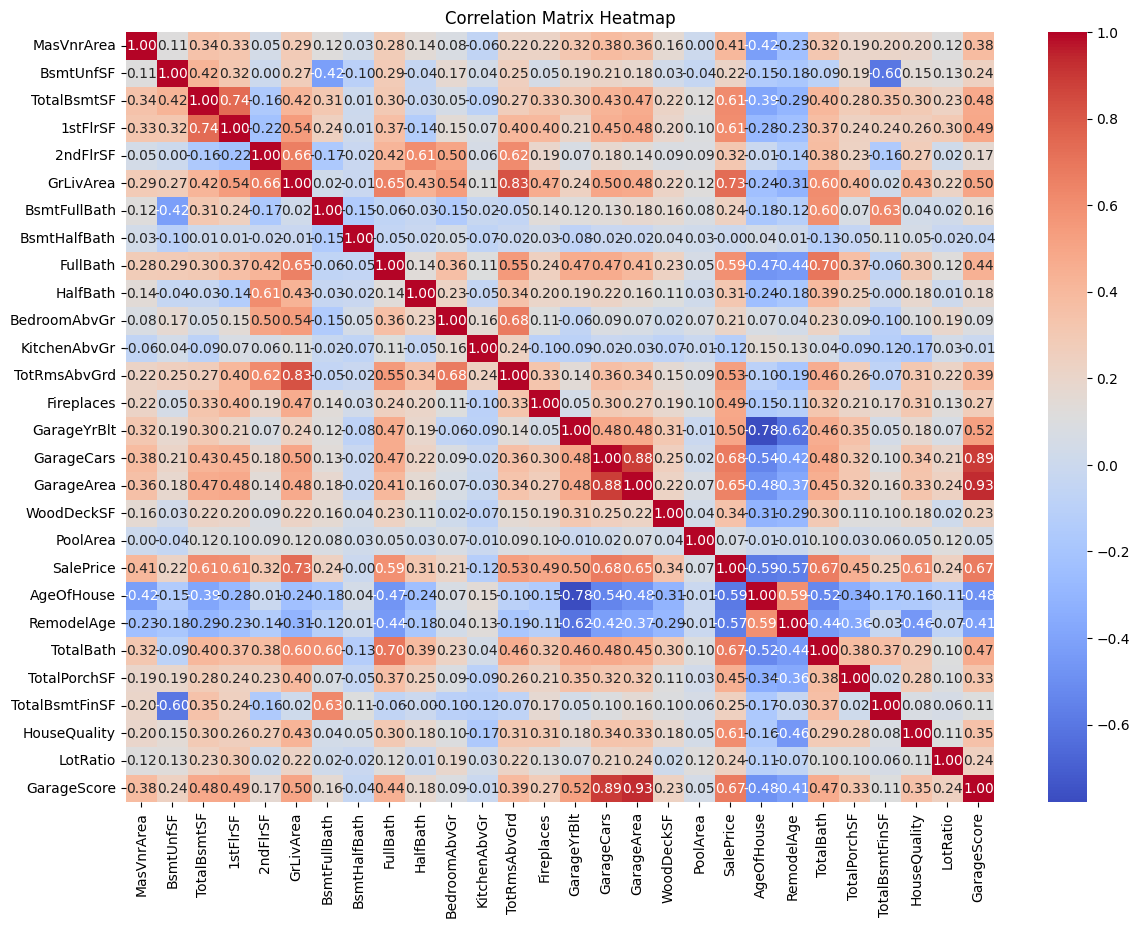

In [52]:
nf=nfvalue(df)

# Calculate the correlation matrix
correlation_matrix = nf.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')

In [53]:
# Display correlation with SalePrice
saleprice_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Select features with correlation above 0.40
selected_features = saleprice_correlation[saleprice_correlation > 0.10].index

# Remove 'SalePrice' from the list using list comprehension
selected_features = [feature for feature in selected_features if feature != 'SalePrice']
                     
print("Features with correlation above 0.10 with SalePrice:")
print(selected_features,len(selected_features))

Features with correlation above 0.10 with SalePrice:
['GrLivArea', 'GarageCars', 'GarageScore', 'TotalBath', 'GarageArea', 'TotalBsmtSF', 'HouseQuality', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'Fireplaces', 'TotalPorchSF', 'MasVnrArea', 'WoodDeckSF', '2ndFlrSF', 'HalfBath', 'TotalBsmtFinSF', 'LotRatio', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr'] 22


In [54]:

# Prepare data for modeling
# X = df[['GrLivArea', 'GarageCars', 'GarageScore', 'TotalBath', 'GarageArea', 'TotalBsmtSF', 'HouseQuality', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'Fireplaces', 'TotalPorchSF', 'MasVnrArea']]
X = df[selected_features] 
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

# Optimal number of features
optimal_features = X.columns[rfecv.support_]
print("Optimal number of features:", len(optimal_features))
print("Selected features:", optimal_features)

Optimal number of features: 20
Selected features: Index(['GrLivArea', 'GarageCars', 'GarageScore', 'TotalBath', 'GarageArea',
       'TotalBsmtSF', 'HouseQuality', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
       'GarageYrBlt', 'Fireplaces', 'TotalPorchSF', 'MasVnrArea', 'WoodDeckSF',
       '2ndFlrSF', 'TotalBsmtFinSF', 'LotRatio', 'BsmtUnfSF', 'BedroomAbvGr'],
      dtype='object')


In [55]:
#test data optimal feature
df_test=df_test[optimal_features]
if len(df_test.columns)== len(df[optimal_features].columns):
    print('true')

true


In [56]:
df_test.isnull().sum()

GrLivArea           0
GarageCars          1
GarageScore        78
TotalBath           2
GarageArea          1
TotalBsmtSF         1
HouseQuality        0
1stFlrSF            0
FullBath            0
TotRmsAbvGrd        0
GarageYrBlt        78
Fireplaces          0
TotalPorchSF        0
MasVnrArea         15
WoodDeckSF          0
2ndFlrSF            0
TotalBsmtFinSF      1
LotRatio          227
BsmtUnfSF           1
BedroomAbvGr        0
dtype: int64

In [57]:
tnf=nfvalue(df_test)
mean_values = tnf.mean()
print(mean_values)
# Replace missing values with mean
df_test.loc[:, :] = df_test.fillna(mean_values)


GrLivArea         1486.045922
GarageCars           1.766118
GarageScore       3100.100652
TotalBath            2.226150
GarageArea         472.768861
TotalBsmtSF       1046.117970
HouseQuality        33.607265
1stFlrSF          1156.534613
FullBath             1.570939
TotRmsAbvGrd         6.385195
GarageYrBlt       1977.721217
Fireplaces           0.581220
TotalPorchSF        91.416038
MasVnrArea         100.709141
WoodDeckSF          93.174777
2ndFlrSF           325.967786
TotalBsmtFinSF     491.823045
LotRatio             0.007933
BsmtUnfSF          554.294925
BedroomAbvGr         2.854010
dtype: float64


In [58]:
df_test.isnull().sum()

GrLivArea         0
GarageCars        0
GarageScore       0
TotalBath         0
GarageArea        0
TotalBsmtSF       0
HouseQuality      0
1stFlrSF          0
FullBath          0
TotRmsAbvGrd      0
GarageYrBlt       0
Fireplaces        0
TotalPorchSF      0
MasVnrArea        0
WoodDeckSF        0
2ndFlrSF          0
TotalBsmtFinSF    0
LotRatio          0
BsmtUnfSF         0
BedroomAbvGr      0
dtype: int64

In [59]:
# Define the target variable and features
y = df['SalePrice']
X = df[optimal_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Function to train and evaluate a single model
def train_evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
    return name, rmse

# Parallel processing for model evaluation
results = Parallel(n_jobs=-1)(delayed(train_evaluate_model)(name, model, X_train_pca, y_train, X_test_pca, y_test) for name, model in models.items())

# Print results
for name, rmse in results:
    print(f'{name}: RMSE with PCA = {rmse:.2f}')

# Hyperparameter tuning (example with Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)
best_rf = grid_search.best_estimator_

# Save the final model
joblib.dump(best_rf, 'best_random_forest_model_pca.pkl')

# Load the model (for deployment)
loaded_model = joblib.load('best_random_forest_model_pca.pkl')

# Make predictions with the loaded model
final_predictions = loaded_model.predict(X_test_pca)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = final_mse ** 0.5
print(f'Final Random Forest Model with PCA: RMSE = {final_rmse:.2f}')


# Evaluate the model
r2rf = r2_score(y_test, final_predictions)


Linear Regression: RMSE with PCA = 0.06
Ridge Regression: RMSE with PCA = 0.06
Lasso Regression: RMSE with PCA = 0.17
Random Forest: RMSE with PCA = 0.07
Gradient Boosting: RMSE with PCA = 0.06
Final Random Forest Model with PCA: RMSE = 0.07


In [60]:
r2rf

0.8478429194409792

In [61]:
# Assuming df_test is your new DataFrame
# Scale the new data
df_test_scaled = scaler.transform(df_test)

# Apply PCA to the scaled data
df_test_pca = pca.transform(df_test_scaled)

# Make predictions with the loaded model
new_predictions_rando = loaded_model.predict(df_test_pca)

# Print the predictions
print(f'Predictions for df_test: {new_predictions_rando}')


Predictions for df_test: [8.0629194  8.0629194  8.06078927 ... 8.06406684 8.06137867 8.06078927]


In [62]:
df_test_rando=df_test.copy()
# Add predictions to the new data using .loc
df_test_rando.loc[:, 'Predicted_salePrice'] = new_predictions_rando
df_test_rando.head(10)

,GrLivArea,GarageCars,GarageScore,TotalBath,GarageArea,TotalBsmtSF,HouseQuality,1stFlrSF,FullBath,TotRmsAbvGrd,...,Fireplaces,TotalPorchSF,MasVnrArea,WoodDeckSF,2ndFlrSF,TotalBsmtFinSF,LotRatio,BsmtUnfSF,BedroomAbvGr,Predicted_salePrice
0,896,1.0,2190.0,1.0,730.0,882.0,30,896,1,5,...,0,120,0.0,140,0,612.0,0.006883,270.0,2,8.062919
1,1329,1.0,936.0,1.5,312.0,1329.0,36,1329,1,6,...,0,36,108.0,393,0,923.0,0.005677,406.0,3,8.062919
2,1629,2.0,2892.0,2.5,482.0,928.0,25,928,2,6,...,1,34,0.0,212,701,791.0,0.005351,137.0,3,8.060789
3,1604,2.0,2820.0,2.5,470.0,926.0,36,926,2,7,...,1,36,20.0,360,678,602.0,0.007817,324.0,3,8.060789
4,1280,2.0,3036.0,2.0,506.0,1280.0,40,1280,2,5,...,0,226,0.0,0,0,263.0,0.008591,1017.0,2,8.062919
5,1655,2.0,2640.0,2.5,440.0,763.0,30,763,2,7,...,1,84,0.0,157,892,0.0,0.007500,763.0,3,8.060789
6,1187,2.0,2520.0,3.0,420.0,1168.0,42,1187,2,6,...,0,21,0.0,483,0,935.0,0.007933,233.0,3,8.073126
7,1465,2.0,2358.0,2.5,393.0,789.0,30,789,2,7,...,1,75,0.0,0,676,0.0,0.007498,789.0,3,8.045049
8,1341,2.0,3036.0,2.5,506.0,1300.0,35,1341,1,5,...,1,0,0.0,192,0,637.0,0.008353,663.0,2,8.061379
9,882,2.0,3150.0,2.0,525.0,882.0,20,882,1,4,...,0,0,0.0,240,0,882.0,0.008333,0.0,2,8.064067


In [63]:

# Define the target variable and features
y = df['SalePrice']
X = df[optimal_features]

#the data is already scaled above, so i dont scale, pca the data anymore.

# Initialize the XGBoost model with GPU support
xgb_model = xgb.XGBRegressor(tree_method = "hist", device = "cuda", random_state=42)

# Train the XGBoost model
xgb_model.fit(X_train_scaled, y_train)

# Save the trained model and scaler
dump(xgb_model, 'xgb_model.pkl')
dump(scaler, 'scaler.pkl')

# Load the trained model and scaler
xgb_model = load('xgb_model.pkl')
scaler = load('scaler.pkl')

# Make predictions on the test set
predictions = xgb_model.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:07:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [64]:
print(f'R-squared: {r2}')

R-squared: 0.8482206334691162


# Predicting

lets try and use the test data

In [65]:
df_test=df_test.copy()
# Ensure the new data has the same features
X_new = df_test[optimal_features]

# Apply the same preprocessing steps
X_new_scaled = scaler.transform(X_new)

# Make predictions on the new data
new_predictions = xgb_model.predict(X_new_scaled)

# Add predictions to the new data using .loc
df_test.loc[:, 'Predicted_salePrice'] = new_predictions
# df_test.to_csv('predicted_new_dataset.csv', index=False)

df_test.head()

,GrLivArea,GarageCars,GarageScore,TotalBath,GarageArea,TotalBsmtSF,HouseQuality,1stFlrSF,FullBath,TotRmsAbvGrd,...,Fireplaces,TotalPorchSF,MasVnrArea,WoodDeckSF,2ndFlrSF,TotalBsmtFinSF,LotRatio,BsmtUnfSF,BedroomAbvGr,Predicted_salePrice
0,896,1.0,2190.0,1.0,730.0,882.0,30,896,1,5,...,0,120,0.0,140,0,612.0,0.006883,270.0,2,7.854651
1,1329,1.0,936.0,1.5,312.0,1329.0,36,1329,1,6,...,0,36,108.0,393,0,923.0,0.005677,406.0,3,7.942725
2,1629,2.0,2892.0,2.5,482.0,928.0,25,928,2,6,...,1,34,0.0,212,701,791.0,0.005351,137.0,3,7.907053
3,1604,2.0,2820.0,2.5,470.0,926.0,36,926,2,7,...,1,36,20.0,360,678,602.0,0.007817,324.0,3,7.961101
4,1280,2.0,3036.0,2.0,506.0,1280.0,40,1280,2,5,...,0,226,0.0,0,0,263.0,0.008591,1017.0,2,8.031484


In [66]:
# Define df_conclusion as an empty DataFrame with the desired columns
df_conclusion = pd.DataFrame(columns=['linear', 'randomforest'])

# Assign values to the columns
df_conclusion['linear'] = df_test['Predicted_salePrice']
df_conclusion['randomforest'] = df_test_rando['Predicted_salePrice']

# Display the DataFrame
print(df_conclusion.sum())


linear          11529.831055
randomforest    11758.884184
dtype: float64


In [67]:
submission=pd.DataFrame()
submission['Id']=Id
submission['Id'] = submission['Id'].astype(int)
submission['SalePrice']=df_conclusion['linear']

submission.to_csv('submission.csv', index=False)
submission.head()


,Id,SalePrice
0,1461,7.854651
1,1462,7.942725
2,1463,7.907053
3,1464,7.961101
4,1465,8.031484


so in conclusion, this note book uses  mean imputation for numeric, mode imputation for categoric, feature engineering for data cleaning. as for the data understanding, i use skewness,correlation map, df.info, and describe. and i use Recursive Feature Elimination with Cross-Validation to select the optimal feature to be used. 

and from that i deemed that ill use liniear regression as it have a rather smaller rmse than the random forest in this dataset.

after doing all that the accuracy that i get is 85% which is a good enough number for this price prediction but can be optimized further.